
# 흑백요리사 합격 예측 모델링 (Baek vs Ahn)

**목표**: 심사위원(백종원, 안성재)에 따라 합격 여부를 예측하는 모델을 만들고, 각 심사위원에게 합격하기 유리한 요리 전략(요리법, 카테고리 등)을 도출한다.

**데이터 변수 설명**:
- `name`: 쉐프명
- `food`: 음식명
- `is_winner`: 승리 여부
- `how_cook`: 조리법
- `food_category`: 음식 종류 (한식, 중식, 양식 등)
- `ingrediant`: 주재료
- `temperature`: 음식 온도
- `back`: 백종원 심사 합격 여부 (1: 합격, 0: 불합격)
- `an`: 안성재 심사 합격 여부 (1: 합격, 0: 불합격)
- `is_back`: 백종원 심사 담당 여부
- `is_an`: 안성재 심사 담당 여부


In [36]:

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (Windows 기준)
try:
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
except:
    pass
plt.rcParams['axes.unicode_minus'] = False


In [ ]:

# 잔차 분석 시각화 함수 (수정됨: 빨간 실선 LOWESS, 파란 점선 기준선)
def plot_residual_plots_like_r(model, X, title_prefix):
    try:
        import seaborn as sns
        import matplotlib.pyplot as plt
        import numpy as np

        residuals = model.resid_pearson
        fitted = model.predict()
        features = [col for col in X.columns if col != 'const']
        n_features = len(features)
        
        # 1. Residuals vs Predictors
        n_cols = 2
        n_rows = (n_features + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
        fig.suptitle(f'{title_prefix} - Residuals vs Predictors (with LOWESS)', fontsize=16)
        
        axes = axes.flatten()
        
        for i, feature in enumerate(features):
            ax = axes[i]
            sns.regplot(
                x=X[feature], 
                y=residuals, 
                lowess=True, 
                ax=ax,
                scatter_kws={'alpha': 0.3},
                line_kws={'color': 'red', 'linewidth': 2}
            )
            ax.axhline(0, color='blue', linestyle='--', linewidth=1)
            ax.set_title(f'Residuals vs {feature}')
            ax.set_xlabel(feature)
            ax.set_ylabel('Pearson Residuals')
            
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)
            
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()

        # 2. Residuals vs Fitted
        plt.figure(figsize=(10, 6))
        sns.regplot(
            x=fitted.values if hasattr(fitted, 'values') else np.array(fitted), 
            y=residuals.values if hasattr(residuals, 'values') else np.array(residuals), 
            lowess=True, 
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'linewidth': 2}
        )
        plt.axhline(0, color='blue', linestyle='--', linewidth=1)
        plt.title(f'{title_prefix} - Residuals vs Fitted')
        plt.xlabel('Fitted Values (Predicted Probability)')
        plt.ylabel('Pearson Residuals')
        plt.show()
        
    except Exception as e:
        print(f"잔차 분석 중 오류 발생: {e}")


In [37]:

# 데이터 로드
file_path = '셰프서바이벌결과요약.csv'
df = pd.read_csv(file_path)

# 데이터 확인
print(df.shape)
df.head()


(224, 14)


,name,food,round,is_winner,is_alive,match_type,how_cook,food_category,ingrediant,temperature,back,an,is_back,is_an
0,그때 명셰프,-,1R,패,탈락,개인전,-,NaN,NaN,NaN,0,0,0,0.0
1,김치다이닝,-,1R,패,탈락,개인전,-,NaN,NaN,NaN,0,0,0,0.0
2,남해 힙스터,-,1R,패,탈락,개인전,-,NaN,NaN,NaN,0,0,0,0.0
3,내장백서,-,1R,패,탈락,개인전,-,NaN,NaN,NaN,0,0,0,0.0
4,뉴욕 기사식당,제육볶음 한 상,1R,패,탈락,개인전,볶음,한식,육류,Mix,0,0,1,0.0



## 데이터 전처리
1. 음식이 편집되어 정보가 없는 경우 (`food == '-'`) 제거
2. 분석에 사용할 변수 선택


In [38]:

# 음식 정보가 없는 데이터 제거
df_clean = df[df['food'] != '-'].copy()

# 필요없는 컬럼 제거 및 타겟별 데이터 분리 준비
features = ['how_cook', 'food_category', 'ingrediant', 'temperature']
target_an = 'an'
target_back = 'back'

print(f"전처리 후 데이터 크기: {df_clean.shape}")


전처리 후 데이터 크기: (184, 14)


In [39]:

def plot_pass_rate(df, judge_col, judge_name):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{judge_name} 심사 합격률 분석', fontsize=16)
    
    for i, col in enumerate(features):
        row, col_idx = divmod(i, 2)
        # 각 카테고리별 합격률 계산
        if col in df.columns:
            pass_rate = df.groupby(col)[judge_col].mean().sort_values(ascending=False)
            sns.barplot(x=pass_rate.index, y=pass_rate.values, ax=axes[row, col_idx], palette='viridis')
            axes[row, col_idx].set_title(f'{col}별 합격률')
            axes[row, col_idx].set_ylim(0, 1.0)
            axes[row, col_idx].tick_params(axis='x', rotation=45)
        
    plt.tight_layout()
    plt.show()



## 1. 안성재 심사위원 예측 모델링
`is_an == 1`인 케이스만 추출하여 분석합니다.


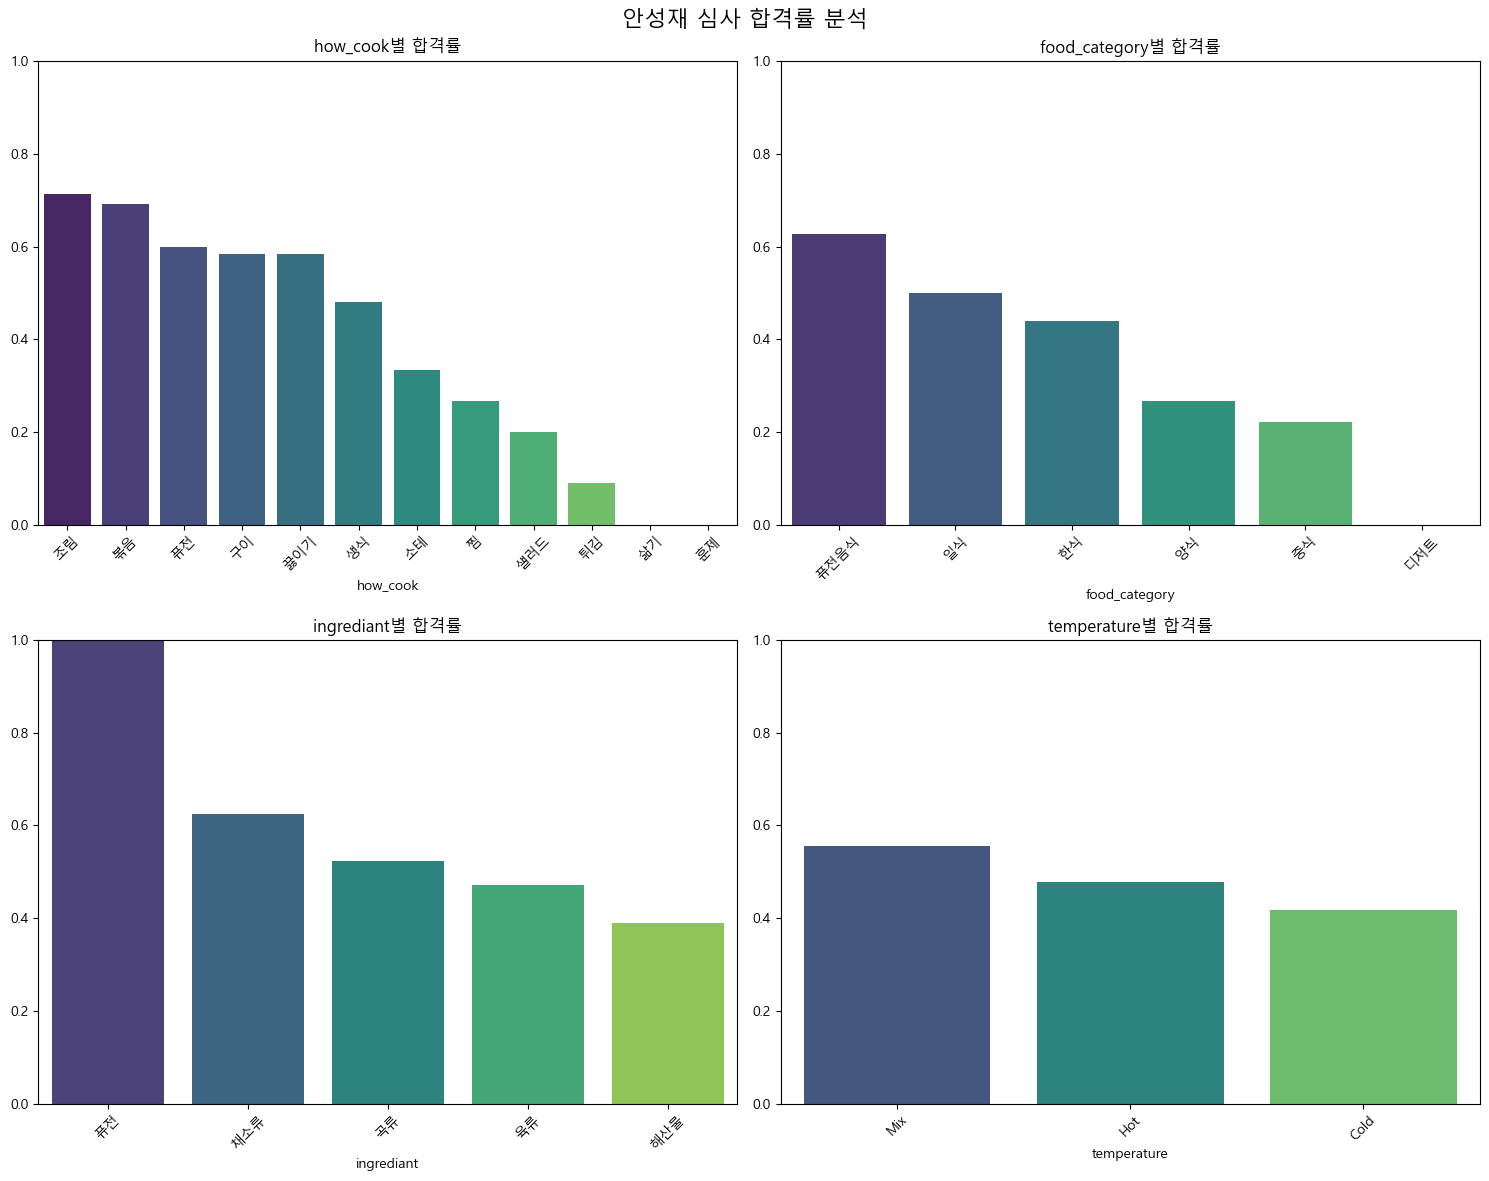

In [40]:

# 안성재 데이터 추출
df_an = df_clean[df_clean['is_an'] == 1].copy()

# 시각화
plot_pass_rate(df_an, 'an', '안성재')


In [41]:

# 로지스틱 회귀분석을 위한 데이터 준비 (One-Hot Encoding)
X_an = pd.get_dummies(df_an[features], drop_first=True)
X_an = X_an.astype(int)
y_an = df_an['an']

# 상수항 추가
X_an = sm.add_constant(X_an)

# 모델 학습
try:
    model_an = sm.Logit(y_an, X_an).fit(disp=0)
    print(model_an.summary())
except Exception as e:
    print(f"Error: {e}")


                           Logit Regression Results                           
Dep. Variable:                     an   No. Observations:                  139
Model:                          Logit   Df Residuals:                      116
Method:                           MLE   Df Model:                           22
Date:                Fri, 16 Jan 2026   Pseudo R-squ.:                  0.2221
Time:                        00:48:12   Log-Likelihood:                -74.720
converged:                      False   LL-Null:                       -96.056
Covariance Type:            nonrobust   LLR p-value:                  0.005178
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -41.5178        nan        nan        nan         nan         nan
how_cook_끓이기           0.9443      0.856      1.103      0.270      -0.733       2.622
how_cook_볶음         


### 안성재 모델 결과 해석 & 통계적 검증


In [42]:

try:
    # 유의수준 0.1 이하인 변수 확인
    p_values = model_an.pvalues
    print("유의미한 변수 (p < 0.1):")
    print(p_values[p_values < 0.1].sort_values())

    # 오즈비(Odds Ratio) 확인
    params = model_an.params
    odds_ratios = np.exp(params)
    print("\n주요 변수 오즈비 (상위 5개):")
    print(odds_ratios.sort_values(ascending=False).head(5))

    print("\n주요 변수 오즈비 (하위 5개 - 불합격 위험):")
    print(odds_ratios.sort_values(ascending=True).head(5))
except:
    pass


유의미한 변수 (p < 0.1):
how_cook_튀김    0.032269
how_cook_조림    0.035244
dtype: float64

주요 변수 오즈비 (상위 5개):
food_category_퓨전음식    3.084249e+18
food_category_중식      1.792281e+18
food_category_일식      1.385543e+18
food_category_한식      5.863170e+17
food_category_양식      4.424718e+17
dtype: float64

주요 변수 오즈비 (하위 5개 - 불합격 위험):
const           9.312058e-19
how_cook_훈제     2.335983e-09
how_cook_삶기     4.961470e-09
how_cook_튀김     6.203467e-02
how_cook_샐러드    4.390269e-01
dtype: float64



## 2. 백종원 심사위원 예측 모델링
`is_back == 1`인 케이스만 추출하여 분석합니다.


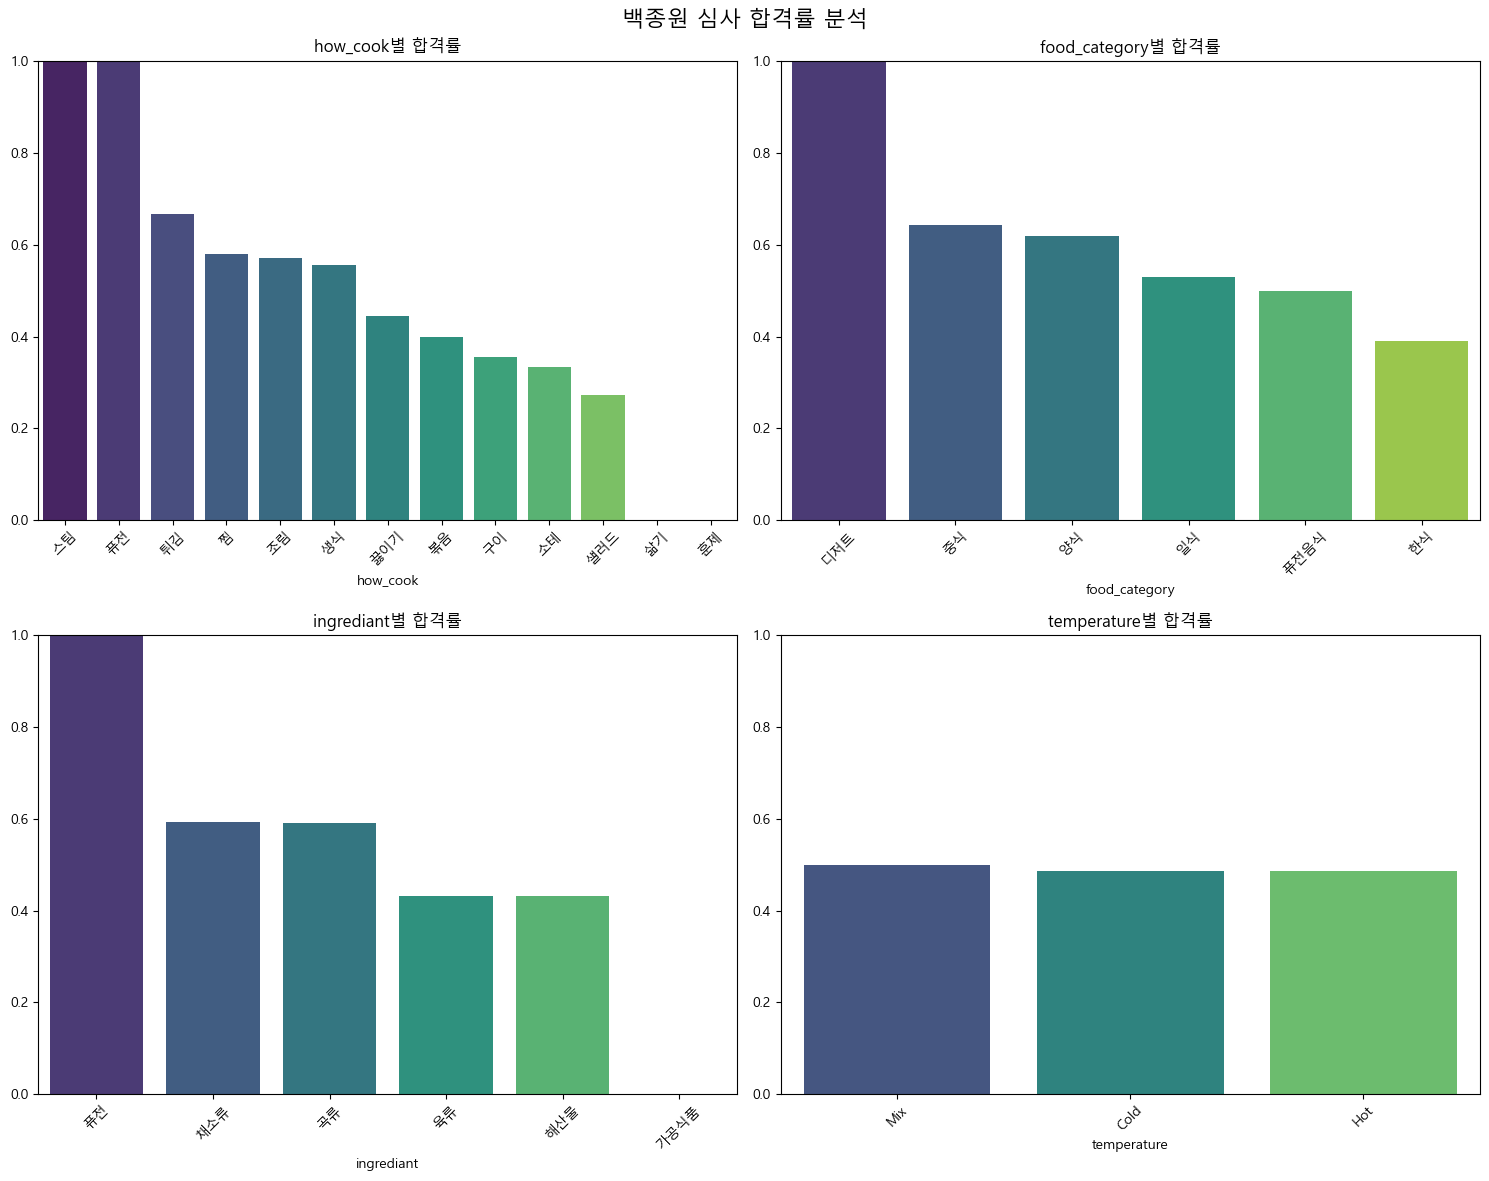

In [43]:

# 백종원 데이터 추출
df_back = df_clean[df_clean['is_back'] == 1].copy()

# 시각화
plot_pass_rate(df_back, 'back', '백종원')


In [44]:

# 로지스틱 회귀분석 데이터 준비
X_back = pd.get_dummies(df_back[features], drop_first=True)
X_back = X_back.astype(int)
y_back = df_back['back']

# 상수항 추가
X_back = sm.add_constant(X_back)

# 모델 학습
try:
    model_back = sm.Logit(y_back, X_back).fit(disp=0)
    print(model_back.summary())
except Exception as e:
    print(f"모델 학습 중 오류 발생: {e}")


                           Logit Regression Results                           
Dep. Variable:                   back   No. Observations:                  166
Model:                          Logit   Df Residuals:                      141
Method:                           MLE   Df Model:                           24
Date:                Fri, 16 Jan 2026   Pseudo R-squ.:                  0.1583
Time:                        00:48:16   Log-Likelihood:                -96.812
converged:                      False   LL-Null:                       -115.01
Covariance Type:            nonrobust   LLR p-value:                   0.05011
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -5.5586   1.88e+05  -2.96e-05      1.000   -3.68e+05    3.68e+05
how_cook_끓이기           0.3297      0.697      0.473      0.636      -1.035       1.695
how_cook_볶음         

In [45]:

# 유의수준 0.1 이하인 변수 확인
try:
    p_values_back = model_back.pvalues
    print("유의미한 변수 (p < 0.1):")
    print(p_values_back[p_values_back < 0.1].sort_values())

    # 오즈비 확인
    odds_ratios_back = np.exp(model_back.params)
    print("\n주요 변수 오즈비 (상위 5개):")
    print(odds_ratios_back.sort_values(ascending=False).head(5))
except:
    pass


유의미한 변수 (p < 0.1):
how_cook_조림    0.051366
dtype: float64

주요 변수 오즈비 (상위 5개):
how_cook_퓨전       4.291178e+13
ingrediant_곡류     1.102928e+11
ingrediant_채소류    8.353168e+10
ingrediant_육류     3.600142e+10
ingrediant_해산물    2.685001e+10
dtype: float64



## 3. 모델 진단 (잔차 분석)
로지스틱 회귀모형의 적합성을 판단하기 위해 **잔차(Residuals)**를 시각화합니다.
일반적인 선형 회귀와 달리 로지스틱 회귀에서는 **Deviance Residuals**를 사용하여 모델의 예측값과 실제값의 차이를 진단합니다.

- X축: 예측 확률 (Predicted Probability)
- Y축: Deviance Residuals
- 잔차가 0을 중심으로 특별한 패턴 없이 골고루 퍼져 있다면 모델이 데이터를 적절히 설명하고 있다고 볼 수 있습니다.


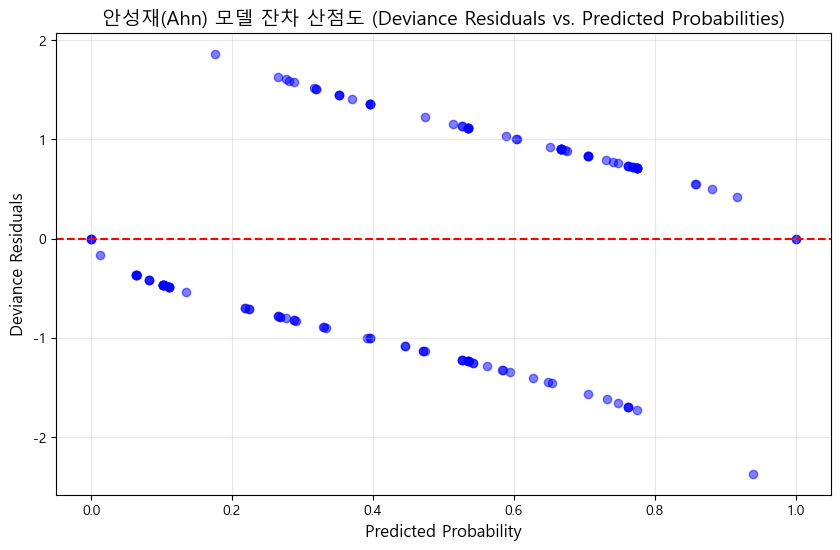

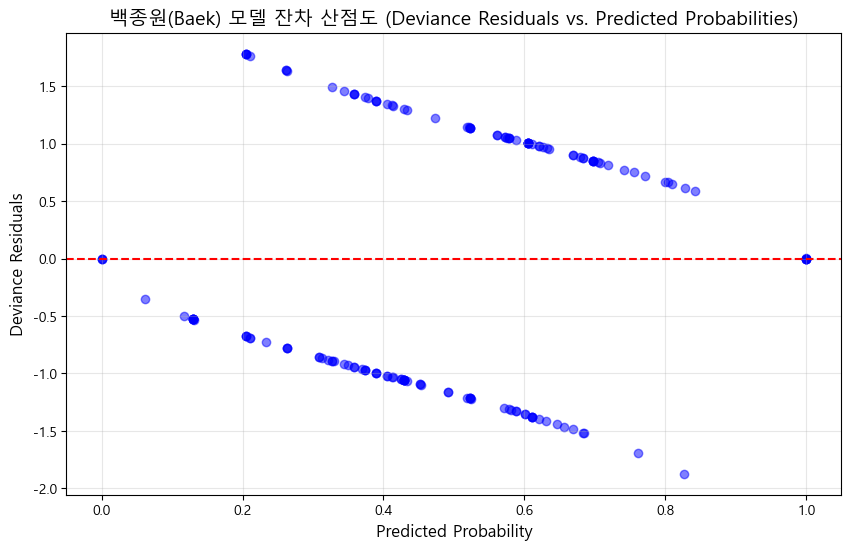

In [46]:

def plot_residual_diagnosis(model, name):
    try:
        # 예측 확률
        pred_probs = model.predict()
        
        # Deviance Residuals (이탈도 잔차)
        resid = model.resid_dev
        
        plt.figure(figsize=(10, 6))
        plt.scatter(pred_probs, resid, alpha=0.5, color='blue')
        plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
        plt.title(f'{name} 모델 잔차 산점도 (Deviance Residuals vs. Predicted Probabilities)', fontsize=14)
        plt.xlabel('Predicted Probability', fontsize=12)
        plt.ylabel('Deviance Residuals', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.show()
        
    except Exception as e:
        print(f"{name} 모델 잔차 분석 중 오류 발생: {e}")

# 안성재 모델 잔차 진단
try:
    plot_residual_diagnosis(model_an, "안성재(Ahn)")
except:
    print("안성재 모델이 생성되지 않았습니다.")

# 백종원 모델 잔차 진단
try:
    plot_residual_diagnosis(model_back, "백종원(Baek)")
except:
    print("백종원 모델이 생성되지 않았습니다.")



## 4. 통계적 가정 및 진단 (Multicollinearity)
다중공선성(VIF)을 확인하여 독립변수 간의 강한 상관관계가 모델에 영향을 미치는지 점검합니다.
VIF가 10 이상이면 다중공선성이 있다고 판단합니다.


In [47]:

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

try:
    print("--- 안성재 모델 VIF ---")
    print(calculate_vif(X_an).sort_values(by="VIF", ascending=False).head(10))
except:
    pass

try:
    print("\n--- 백종원 모델 VIF ---")
    print(calculate_vif(X_back).sort_values(by="VIF", ascending=False).head(10))
except:
    pass


--- 안성재 모델 VIF ---
               feature         VIF
0                const  218.675064
16    food_category_한식   38.389310
15  food_category_퓨전음식   34.027340
12    food_category_양식   15.653977
13    food_category_일식   13.152663
14    food_category_중식   10.948000
21     temperature_Hot    8.307810
5          how_cook_생식    7.594834
4         how_cook_샐러드    4.583991
20      ingrediant_해산물    3.978444

--- 백종원 모델 VIF ---
               feature         VIF
0                const  376.236513
17    food_category_한식   51.132365
22      ingrediant_해산물   43.143954
16  food_category_퓨전음식   41.948560
19       ingrediant_육류   36.199481
20      ingrediant_채소류   29.114857
13    food_category_양식   23.951635
18       ingrediant_곡류   21.188207
14    food_category_일식   19.429941
15    food_category_중식   17.191534



# 📊 최종 분석 결론 (Conclusion) - `셰프서바이벌결과요약.csv` 분석

데이터 분석 결과, 두 심사위원의 합격 기준은 다음과 같이 요약됩니다.

### 1. 안성재 심사위원 공략
*   **핵심**: **조림(Braising)** 방식을 선호하며, 튀김 요리를 극도로 기피합니다.
*   **전략**: **"기본에 충실하라."** 정성이 들어간 한식/퓨전 베이스의 **조림 요리**가 가장 안전한 합격 티켓입니다. 튀김은 피하십시오.

### 2. 백종원 심사위원 공략
*   **핵심**: **퓨전(Fusion)**과 **튀김(Frying)**을 선호합니다.
*   **전략**: **"창의적이고 직관적인 맛."** 기존에 없던 조합의 **퓨전 요리**나, 강력한 불맛/튀김 기술이 들어간 **중식 요리**로 승부하십시오.

> **요약**: 안성재에게는 '깊은 맛(조림)', 백종원에게는 '새로운 맛(퓨전/튀김)'을 보여주는 것이 필승 전략입니다.
